In [1]:
import pandas as pd
import json
from datetime import datetime

# Read the log file
for id in range(1, 13):
    log_file_path = f'log/P{id}.log'

    with open(log_file_path, 'r') as f:
        log_lines = f.readlines()

    # Prepare lists for columns
    timestamps = []
    events = []
    details = []

    for line in log_lines:
        line = line.strip()
        if not line:
            continue
        try:
            json_start = line.find('{"timestamp"')
            if json_start != -1:
                json_data = json.loads(line[json_start:])
                
                # timestamp 처리 (시:분:초만)
                if 'timestamp' in json_data:
                    try:
                        t = datetime.fromisoformat(json_data['timestamp'])
                        timestamps.append(t.strftime("%H:%M:%S"))
                    except ValueError:
                        timestamps.append(json_data['timestamp'])  # 포맷 안맞으면 원본 사용
                else:
                    timestamps.append(None)
                
                events.append(json_data.get('event', None))
                details.append(json_data.get('details', None))
            else:
                # JSON이 없으면 전체를 이벤트로 취급
                timestamps.append(None)
                events.append(line)
                details.append(None)
        except json.JSONDecodeError:
            timestamps.append(None)
            events.append(line)
            details.append(None)

    # DataFrame 생성
    df = pd.DataFrame({
        'timestamp': timestamps,
        'event': events,
        'details': details
    })

    # print(df)
    print(f"\nTotal events: {len(df)}")
    # print(f"Unique event types: {df['event'].unique()}")
    sorted_events = sorted(df['event'].dropna().unique())
    for event in sorted(df['event'].dropna().unique()):
        print(event)

    # events_to_keep = ['class.created', 'caption_generated']
    # df_filtered = df[df['event'].isin(events_to_keep)]

    # events_to_remove = ['api.generate_description.started', 'api.generate_image.started', 'api.generate_instance_label_from_description.started', 'api.generate_placeholders.started', 'api.generate_scene_graph_to_text.started', 'api.generate_text_to_graph.started', '']
    # df_filtered = df[~df['event'].isin(events_to_remove)]

    df = df[~df['event'].str.startswith('image_', na=False)]
    df = df[~df['event'].str.startswith('generate_', na=False)]
    # df = df[~df['event'].str.endswith('started', na=False)]
    # df = df[~df['event'].str.endswith('opened', na=False)]
    # df = df[~df['event'].str.endswith('initiated', na=False)]
    df = df[~df['event'].str.endswith('hovered', na=False)]
    df = df[~df['event'].str.endswith('resized', na=False)]

    df_filtered = df.reset_index(drop=True)

    print(df_filtered)
    df_filtered.to_csv(f'csv/P{id}_filtered.csv', index=False)


Total events: 723
api.generate_description.started
api.generate_description.succeeded
api.generate_image.started
api.generate_image.succeeded
api.generate_instance_label_from_description.started
api.generate_instance_label_from_description.succeeded
api.generate_placeholders.started
api.generate_placeholders.succeeded
api.generate_scene_graph_to_text.started
api.generate_scene_graph_to_text.succeeded
api.generate_text_to_graph.started
api.generate_text_to_graph.succeeded
baselineboard.imagegen.extracted
baselineboard.imagegen.started
baselineboard.imagegen.succeeded
baselineboard.node.add.instance
baselineboard.node.edit
baselineboard.node.moved
class.create.started
class.created
class_detail_opened
class_library_toggle
describe_region_saved
describe_requested
describe_result
experiment_started
generate_caption_completed
generate_caption_requested
image_generation_completed
image_generation_requested
image_quality_modal.rating_submitted
image_quality_rated
image_saved
image_with_layou

/var/folders/yy/wmmdvn295kn5535yf3g57f2m0000gn/T/ipykernel_78326/185158936.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


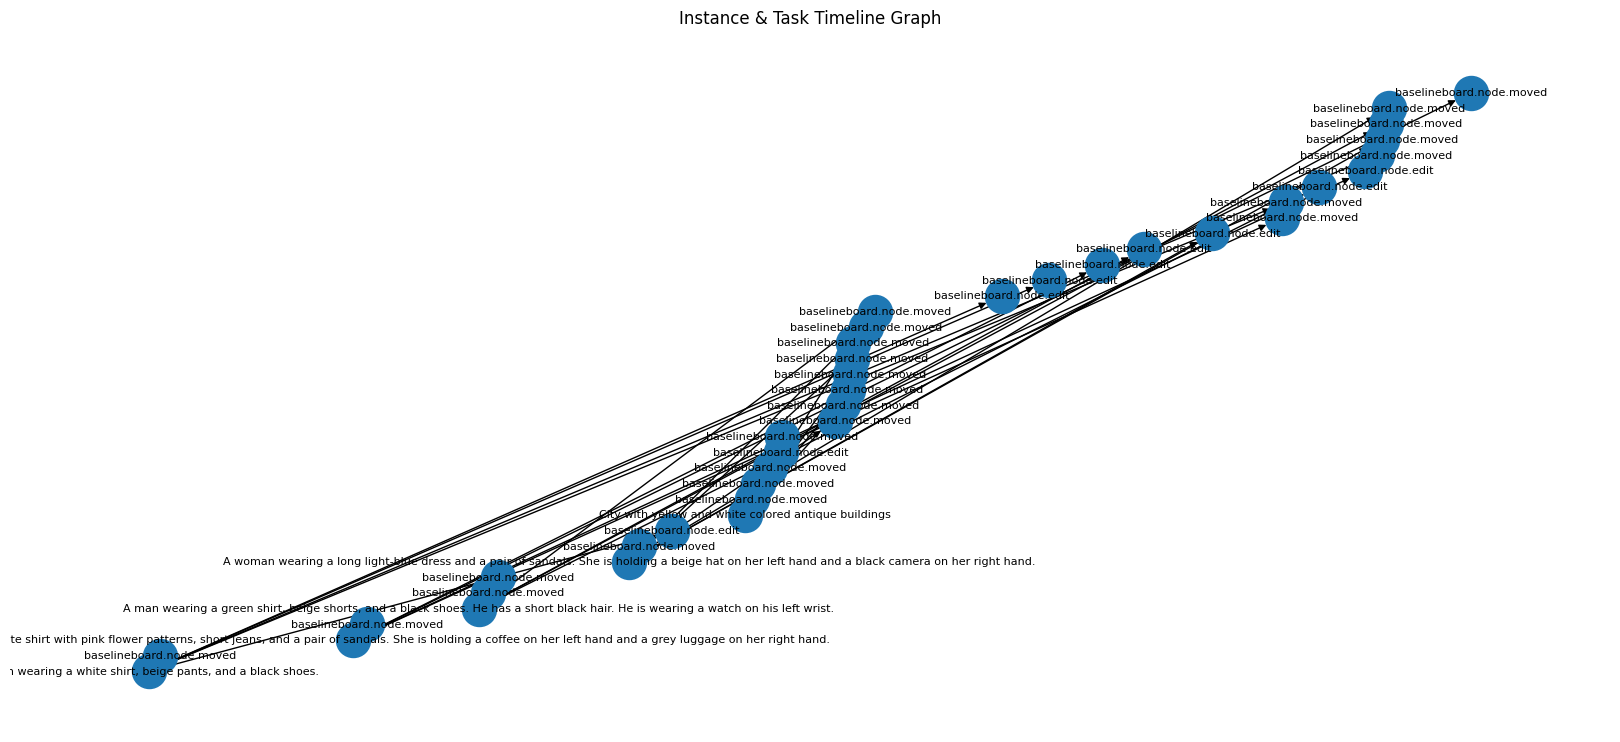

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import ast

# 0) CSV 로드
df = pd.read_csv(f'csv/P{id}_filtered.csv')

# 1) timestamp -> datetime (날짜가 없으니 임의의 동일 날짜로 붙임)
#    필요하면 date를 실험 날짜로 바꾸세요 (예: '2025-08-14 ')
df['timestamp'] = pd.to_datetime('2000-01-01 ' + df['timestamp'], format='%Y-%m-%d %H:%M:%S')

# 2) details를 dict로
df['data_dict'] = df['details'].apply(lambda x: ast.literal_eval(x))

# 3) 헬퍼: resizable suffix 제거해서 instance 기준으로 정규화
def to_instance_id(d):
    if 'instanceId' in d:
        base = d['instanceId']
    elif 'nodeId' in d:
        base = d['nodeId']
    else:
        return None
    return base.replace('-resizable', '')

# 4) 인스턴스 생성 이벤트 (현재 데이터 기준)
EV_CREATE = 'baselineboard.node.add.instance'
create_df = df[df['event'] == EV_CREATE].copy()
create_df['instance_id'] = create_df['data_dict'].apply(lambda d: d['instanceId'])

# 5) 인스턴스 관련 작업(수정/이동 등) 이벤트 수집
TASK_EVENTS = {
    'baselineboard.node.edit',
    'baselineboard.node.moved',
    # 필요 시 추가: 'baselineboard.node.delete', ...
}
tasks_df = df[df['event'].isin(TASK_EVENTS)].copy()
tasks_df['instance_id'] = tasks_df['data_dict'].apply(to_instance_id)
tasks_df = tasks_df.dropna(subset=['instance_id'])

# 6) 그래프 생성
G = nx.DiGraph()

# 6-1) 인스턴스 노드 추가 (생성 시각)
for _, row in create_df.iterrows():
    iid = row['instance_id']
    G.add_node(iid, kind='instance', time=row['timestamp'], label=row['data_dict'].get('instanceLabel', iid))

# 6-2) 태스크 노드 + 엣지 (인스턴스 -> 태스크)
for _, row in tasks_df.iterrows():
    iid = row['instance_id']
    if iid not in G:   # 혹시 생성 로그 없이 작업이 먼저 있는 경우 대비
        G.add_node(iid, kind='instance', time=row['timestamp'], label=iid)
    t = row['timestamp']
    ev = row['event']
    # 시간 단위가 겹치면 노드명 충돌하므로 고유 키 보장
    task_node = f"{iid}|{ev}|{int(t.value)}"
    G.add_node(task_node, kind='task', time=t, label=ev)
    G.add_edge(iid, task_node, label=ev)

# 7) 좌표 배치: x=시간(초), y=간격
# pandas Timestamp.value는 ns 단위 int
sorted_nodes = sorted(G.nodes, key=lambda n: G.nodes[n]['time'])
pos = {}
for i, n in enumerate(sorted_nodes):
    ts = G.nodes[n]['time']
    x = ts.value / 1e9  # seconds
    pos[n] = (x, i)     # 간단히 세로로 늘어놓기

# 8) 시각화
plt.figure(figsize=(16, 7))
nx.draw(
    G, pos,
    with_labels=True,
    labels={n: G.nodes[n].get('label', n) for n in G.nodes},
    node_size=600, font_size=8
)
plt.xlabel('Time (s)')
plt.title('Instance & Task Timeline Graph')
plt.tight_layout()
plt.show()


/var/folders/yy/wmmdvn295kn5535yf3g57f2m0000gn/T/ipykernel_78326/3959923233.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


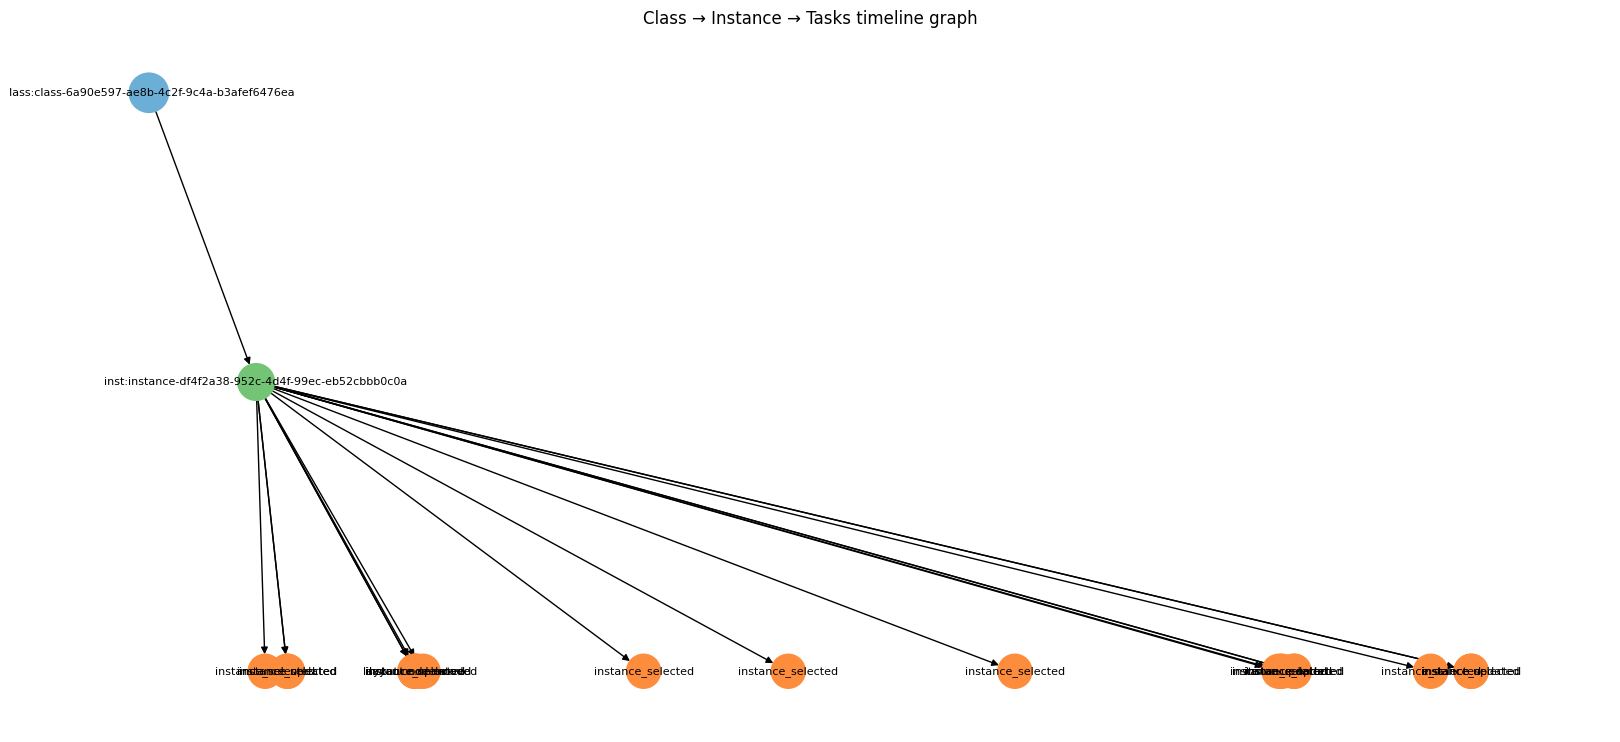

In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import ast
import re

# ========= 설정 =========
CSV_PATH = f'csv/P{id}_OOPT.csv'   # 파일 경로
DATE_PREFIX = '2000-01-01 '        # timestamp가 HH:MM:SS인 경우 붙일 임시 날짜

# ========= 유틸 =========
def parse_details(x):
    if pd.isna(x): return {}
    if isinstance(x, dict): return x
    # CSV에서 문자열로 저장된 dict -> 실제 dict
    return ast.literal_eval(x)

def get_any(d, *keys, default=None):
    for k in keys:
        if k in d: return d[k]
    return default

def normalize_instance_id(raw):
    """instanceId 또는 nodeId에서 -resizable suffix 제거"""
    if raw is None: return None
    return re.sub(r'-resizable$', '', str(raw))

def to_dt(ts):
    """HH:MM:SS or full datetime -> pandas.Timestamp"""
    ts = str(ts)
    if re.fullmatch(r'\d{2}:\d{2}:\d{2}', ts):
        return pd.to_datetime(DATE_PREFIX + ts)
    return pd.to_datetime(ts)

# ========= 1) 로드/파싱 =========
df = pd.read_csv(CSV_PATH)
df['data_dict'] = df['details'].apply(parse_details)
df['timestamp'] = df['timestamp'].apply(to_dt)

# ========= 2) 이벤트 필터링 =========
EV_CLASS_CREATE   = 'class.created'
EV_INST_FROM_CLS  = 'instance.created_from_class'

class_df = df[df['event'] == EV_CLASS_CREATE].copy()
inst_create_df = df[df['event'] == EV_INST_FROM_CLS].copy()

# 클래스/인스턴스 ID 추출(키 변형 대응)
class_df['class_id'] = class_df['data_dict'].apply(lambda d: get_any(d, 'class_id', 'classId'))
inst_create_df['instance_id'] = inst_create_df['data_dict'].apply(lambda d: get_any(d, 'instance_id', 'instanceId'))
inst_create_df['class_id']    = inst_create_df['data_dict'].apply(lambda d: get_any(d, 'class_id', 'classId'))

# 2-1) 인스턴스 생성된 목록
instance_ids = set(inst_create_df['instance_id'].dropna().astype(str))

# ========= 3) 인스턴스 후속 작업 수집 =========
# 'instance_id'가 직접 있거나, nodeId에서 유도되는 경우 포함
def instance_id_from_row(row):
    d = row['data_dict']
    iid = get_any(d, 'instance_id', 'instanceId')
    if iid is None:
        # 이동/편집 이벤트에서 nodeId만 있는 경우
        nid = get_any(d, 'nodeId')
        iid = normalize_instance_id(nid)
    return iid

tasks_df = df[~df['event'].isin([EV_CLASS_CREATE, EV_INST_FROM_CLS])].copy()
tasks_df['instance_id'] = tasks_df.apply(instance_id_from_row, axis=1)
tasks_df = tasks_df[tasks_df['instance_id'].notna()].copy()

# 인스턴스 생성 로그에 등장한 instance만 남기고 싶다면 주석 해제
tasks_df = tasks_df[tasks_df['instance_id'].astype(str).isin(instance_ids)]

# ========= 4) 그래프 구성 =========
G = nx.DiGraph()

# 4-1) 클래스 노드
for _, r in class_df.iterrows():
    cid = str(r['class_id'])
    if cid == 'None': continue
    G.add_node(f"class:{cid}", kind='class', time=r['timestamp'], label=f"class:{cid}")

# 4-2) 인스턴스 노드 및 클래스→인스턴스 엣지
for _, r in inst_create_df.iterrows():
    iid = str(r['instance_id'])
    cid = str(r['class_id'])
    t   = r['timestamp']
    if iid == 'None' or cid == 'None': continue

    G.add_node(f"inst:{iid}", kind='instance', time=t, label=f"inst:{iid}")
    # 클래스 노드가 생성 로그에 없었어도 생략되지 않게 보정
    if f"class:{cid}" not in G:
        G.add_node(f"class:{cid}", kind='class', time=t, label=f"class:{cid}")
    G.add_edge(f"class:{cid}", f"inst:{iid}", label='created_from_class')

# 4-3) 인스턴스 작업 노드(인스턴스→태스크 엣지)
for _, r in tasks_df.iterrows():
    iid = str(r['instance_id'])
    t   = r['timestamp']
    ev  = r['event']
    inst_key = f"inst:{iid}"
    if inst_key not in G:
        # 생성 로그 없이 작업만 있는 경우에도 노드 생성
        G.add_node(inst_key, kind='instance', time=t, label=inst_key)

    # 타임스탬프 ns로 고유 키 보장
    task_key = f"task:{iid}:{ev}:{int(t.value)}"
    G.add_node(task_key, kind='task', time=t, label=ev)
    G.add_edge(inst_key, task_key, label=ev)

# ========= 5) 좌표 배치 (X=시간, Y=레인) =========
# 레인 전략:
#   - 클래스: y=2
#   - 인스턴스: y=1 (인스턴스별로 살짝 오프셋)
#   - 태스크: y=0 (인스턴스별로 살짝 오프셋)
base_time = min(nx.get_node_attributes(G, 'time').values())
def x_coord(ts):
    # 초 단위 상대 시간
    return (ts - base_time).total_seconds()

# 인스턴스별 오프셋 부여(겹침 완화)
inst_nodes = [n for n, d in G.nodes(data=True) if d.get('kind') == 'instance']
inst_to_lane = {n: i for i, n in enumerate(sorted(inst_nodes))}
lane_gap = 0.15

pos = {}
for n, d in G.nodes(data=True):
    t = d['time']
    x = x_coord(t)

    kind = d.get('kind')
    if kind == 'class':
        y = 2.0
    elif kind == 'instance':
        lane = inst_to_lane.get(n, 0)
        y = 1.0 + lane_gap * (lane % 5)   # 여러 인스턴스가 있으면 약간씩 위아래로
    else:  # task
        # 소속 인스턴스 찾아 같은 레인 사용
        preds = list(G.predecessors(n))
        lane_src = preds[0] if preds else None
        lane = inst_to_lane.get(lane_src, 0)
        y = 0.0 + lane_gap * (lane % 5)

    pos[n] = (x, y)

# ========= 6) 시각화 =========
plt.figure(figsize=(16, 7))
labels = {n: G.nodes[n].get('label', n) for n in G.nodes}

# kind별 스타일
node_colors = []
node_sizes = []
for n, d in G.nodes(data=True):
    k = d.get('kind')
    if k == 'class':
        node_colors.append('#6baed6'); node_sizes.append(800)
    elif k == 'instance':
        node_colors.append('#74c476'); node_sizes.append(700)
    else:
        node_colors.append('#fd8d3c'); node_sizes.append(600)

nx.draw(G, pos,
       with_labels=True, labels=labels,
       node_color=node_colors, node_size=node_sizes,
       font_size=8, arrows=True)

plt.xlabel('Time (seconds from first event)')
plt.yticks([0,1,2], ['tasks','instances','classes'])
plt.title('Class → Instance → Tasks timeline graph')
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import ast
import re
for id in range(1, 13):
    CSV_PATH  = f'csv/P{id}_OOPT.csv'   # 앞으로 이 파일 사용
    DATE_STUB = '2000-01-01 '       # HH:MM:SS에 붙일 더미 날짜

    # ----------------- 파싱 유틸 -----------------
    def parse_details(x):
        if pd.isna(x): return {}
        if isinstance(x, dict): return x
        return ast.literal_eval(x)

    def to_dt(ts):
        ts = str(ts)
        if re.fullmatch(r'\d{2}:\d{2}:\d{2}', ts):
            return pd.to_datetime(DATE_STUB + ts)
        return pd.to_datetime(ts)

    def strip_resizable(s: str) -> str:
        return re.sub(r'-resizable$', '', s)

    # ----------------- id 추출 -----------------
    def extract_prioritized_id(d):
        """
        instanceId / instance_id > classId / class_id > nodeId > createdNodeIds
        """
        iid = d.get('instance_id') or d.get('instanceId') or d.get('parent_instance_id')
        if isinstance(iid, str) and iid:
            return strip_resizable(iid)

        cid = d.get('class_id') or d.get('classId')
        if isinstance(cid, str) and cid:
            return cid

        nid = d.get('nodeId')
        if isinstance(nid, str) and nid:
            return nid

        cids = d.get('createdNodeIds')
        if isinstance(cids, (list, tuple)) and len(cids) > 0:
            return str(cids[0])

        return None

    # ----------------- 로드 & 전처리 -----------------
    df = pd.read_csv(CSV_PATH)
    df['details_dict'] = df['details'].apply(parse_details)
    df['timestamp'] = df['timestamp'].apply(to_dt)

    # 1) 제외할 이벤트 목록
    exclude_events = {
        'instance_selected',
        'layout.node.moved',
        'object_node.edit.saved',
        'object_node.attribute.deleted',
        'object_node.expand_collapse'
    }

    # 2) 제외 필터 적용
    df = df[~df['event'].isin(exclude_events)].copy()

    # 3) 우선순위 id 추출
    df['id'] = df['details_dict'].apply(extract_prioritized_id)

    # 4) id가 있거나 event가 new_box_positioned 또는 api.generate_image.succeeded인 이벤트만 남기기
    df_ids = df[df['id'].notna() | (df['event'].isin(['layout_board.new_box_positioned', 'api.generate_image.succeeded']))].copy()

    # 5) 최종 정리
    df_ids = df_ids[['timestamp', 'id', 'event', 'details']].sort_values(['timestamp', 'id']).reset_index(drop=True)

    # ----------------- 출력 예시 -----------------
    print(df_ids.to_string(index=False))

    # 필요 시 저장
    df_ids.to_csv(f'csv/P{id}_OOPT_filtered.csv', index=False)


          timestamp                                            id                           event                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [7]:
for id in range(1, 13):
    CSV_PATH  = f'csv/P{id}_OOPT.csv'   # 앞으로 이 파일 사용

    # ----------------- 로드 & 전처리 -----------------
    df = pd.read_csv(CSV_PATH)
    df['details_dict'] = df['details'].apply(parse_details)
    df['timestamp'] = df['timestamp'].apply(to_dt)

    # 1) 제외할 이벤트 목록
    exclude_events = {
        'instance_selected',
        'layout.node.moved',
        # 'layout.node.resized'
    }

    # 2) 제외 필터 적용
    df = df[~df['event'].isin(exclude_events)].copy()

    # Extract events: instance.updated
    df_updated = df[df['event'] == 'instance.updated'].copy()

    # Count number of graph_changed: "True" or text_changed: "True" in details of the row
    df_updated['graph_changed'] = df_updated['details_dict'].apply(lambda d: d.get('graph_changed'))
    df_updated['text_changed'] = df_updated['details_dict'].apply(lambda d: d.get('text_changed'))

    graph_changed_count = df_updated['graph_changed'].sum()
    text_changed_count = df_updated['text_changed'].sum()

    # print( id, ":", text_changed_count, ",", graph_changed_count)
    print("id:", id)
    print("graph_changed:", graph_changed_count)
    print("text_changed:", text_changed_count)

id: 1
graph_changed: 4
text_changed: 8
id: 2
graph_changed: 1
text_changed: 5
id: 3
graph_changed: 7
text_changed: 13
id: 4
graph_changed: 0
text_changed: 11
id: 5
graph_changed: 7
text_changed: 3
id: 6
graph_changed: 4
text_changed: 8
id: 7
graph_changed: 10
text_changed: 1
id: 8
graph_changed: 9
text_changed: 6
id: 9
graph_changed: 10
text_changed: 12
id: 10
graph_changed: 2
text_changed: 6
id: 11
graph_changed: 2
text_changed: 0
id: 12
graph_changed: 6
text_changed: 8


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# 여러 id 파일을 하나로 합치려면 아래 반복문을 활용하세요
dfs = []
for id in range(1, 13):
    CSV_PATH = f'csv/P{id}_OOPT_filtered.csv'
    df = pd.read_csv(CSV_PATH)
    df['id_group'] = id
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

# 각 id_group별로 첫 이벤트를 0초로 맞추기
if 'timestamp' in df_all.columns:
    if not pd.api.types.is_datetime64_any_dtype(df_all['timestamp']):
        df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
    df_all['time_norm'] = df_all.groupby('id_group')['timestamp'].transform(lambda x: (x - x.min()).dt.total_seconds())
    x = df_all['time_norm']
else:
    x = df_all.index

# id_group별로 y축 배치
id_groups_sorted = sorted(df_all['id_group'].unique())
id_group_to_y = {id_: i for i, id_ in enumerate(id_groups_sorted)}
y = df_all['id_group'].map(id_group_to_y)

# 이벤트 그룹별 색상 팔레트
from matplotlib.colors import to_rgba

base_colors = {
    'class': plt.cm.Blues,   # 파랑 계열
    'instance': plt.cm.Reds, # 빨강 계열 (기존 Greens → Reds)
    'other': plt.cm.Oranges
}

event_types = sorted(df_all['event'].unique())
event_to_group = []
for ev in event_types:
    if ev == 'api.generate_image.succeeded':
        event_to_group.append('api')
    elif ev == 'layout_board.new_box_positioned':
        event_to_group.append('layout')
    elif ev.startswith('class'):
        event_to_group.append('class')
    elif ev.startswith('instance'):
        event_to_group.append('instance')
    else:
        event_to_group.append('other')

# 그룹별로 색상 매핑 (created: 가장 진한, updated: 그 다음 진한)
group_counts = {g: event_to_group.count(g) for g in list(base_colors.keys()) + ['api', 'layout']}
group_color_idx = {g: 0 for g in list(base_colors.keys()) + ['api', 'layout']}
event_to_color = {}
for ev, group in zip(event_types, event_to_group):
    if group == 'api':
        color = 'black'
    elif group == 'layout':
        color = 'gold'
    elif group in ['class', 'instance']:
        cmap = base_colors[group]
        # created: 가장 진한 색 (0.95), updated: 두 번째 진한 색 (0.8)
        if (group == 'class' and ev == 'class.created') or (group == 'instance' and ev == 'instance.created_from_class'):
            color = cmap(0.8)
        elif (group == 'class' and ev == 'class.updated') or (group == 'instance' and ev == 'instance.updated'):
            color = cmap(0.5)
        else:
            idx = group_color_idx[group]
            color = cmap(0.3 + 0.4 * idx / max(1, group_counts[group]-1)) if group_counts[group] > 1 else cmap(0.7)
            group_color_idx[group] += 1
    else:
        cmap = base_colors[group]
        idx = group_color_idx[group]
        color = cmap(0.3 + 0.4 * idx / max(1, group_counts[group]-1)) if group_counts[group] > 1 else cmap(0.7)
        group_color_idx[group] += 1
    event_to_color[ev] = color

# plt.figure(figsize=(20, max(6, len(id_groups_sorted)*0.7)))
# for ev in event_types:
#     mask = df_all['event'] == ev
#     plt.scatter(x[mask], y[mask], color=event_to_color[ev], label=ev, s=50, alpha=0.7)

# plt.xlabel('Time (seconds from first event in each id_group)')
# plt.ylabel('id_group (2~7)')
# plt.yticks(list(id_group_to_y.values()), list(id_group_to_y.keys()))
# plt.title('Event Timeline by id_group (created/updated: most saturated colors)')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

In [1]:
from matplotlib.lines import Line2D
import numpy as np

plt.figure(figsize=(20, max(6, len(id_groups_sorted)*0.7)))
rng = np.random.default_rng(42)

legend_elems = []  # legend 수동 구성

for ev in event_types:
    mask = df_all['event'] == ev
    group = [g for e,g in zip(event_types, event_to_group) if e == ev][0]
    y_jitter = y[mask] #.to_numpy(dtype=float) + rng.uniform(-0.05, 0.05, size=mask.sum())

    # 기본 스타일
    scatter_args = dict(
        x=x[mask],
        y=y_jitter,
        color=event_to_color[ev],
        marker='o',
        s=50,
        alpha=0.7,
        edgecolors='none',
        linewidths=0,
    )

    # 강조 이벤트
    if ev in ['class.created', 'class.updated',
              'instance.created_from_class', 'instance.updated']:
        scatter_args.update(dict(
            s=50,
            edgecolors='k',
            linewidths=0.8,
            zorder=5
        ))

    plt.scatter(**scatter_args)

    # legend entry 생성
    legend_elems.append(
        Line2D([0],[0],
               marker='o',
               color='w',
               markerfacecolor=event_to_color[ev],
               markeredgecolor=('k' if ev in ['class.created','class.updated',
                                              'instance.created_from_class','instance.updated'] else 'none'),
               markersize=(6 if ev in ['class.created','class.updated',
                                       'instance.created_from_class','instance.updated'] else 6),
               label=ev)
    )

plt.xlabel('Time (seconds from first event in each id_group)')
plt.ylabel('id_group (2~7)')
plt.yticks(list(id_group_to_y.values()), list(id_group_to_y.keys()))
plt.title('Event Timeline by id_group (all events, created/updated emphasized)')

plt.legend(handles=legend_elems, bbox_to_anchor=(1.02, 1), loc='upper left', title='Events')
plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined